In [1]:
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

# Define the paths

In [2]:
base_dir = "C:/Users/danis/Coding/crop-disease-recognition-cnn"
preprocessing_dir = os.path.join(base_dir, "Preprocessing")
models_dir = os.path.join(base_dir, "Models")

# Create models directory if it doesn't exist

In [3]:
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Data transformations

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(preprocessing_dir, x), data_transforms[x])
                    for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
                for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Use GPU if available

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained VGG-16 model

In [7]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\danis/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:41<00:00, 13.2MB/s] 


# Define loss function and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function

In [9]:
def train_model(model, criterion, optimizer, num_epochs=10, accumulate_steps=4):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_over_time = []
    val_loss_over_time = []
    train_acc_over_time = []
    val_acc_over_time = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            optimizer.zero_grad()
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if (i + 1) % accumulate_steps == 0:
                            optimizer.step()
                            optimizer.zero_grad()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                optimizer.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record loss and accuracy
            if phase == 'train':
                train_loss_over_time.append(epoch_loss)
                train_acc_over_time.append(epoch_acc.item())
            else:
                val_loss_over_time.append(epoch_loss)
                val_acc_over_time.append(epoch_acc.item())
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, train_loss_over_time, val_loss_over_time, train_acc_over_time, val_acc_over_time, best_acc, time_elapsed


# Train the model

In [10]:
model, train_loss, val_loss, train_acc, val_acc, best_acc, training_time = train_model(model, criterion, optimizer, num_epochs=10, accumulate_steps=4)

Epoch 1/10
----------
train Loss: 1.8873 Acc: 0.3883
val Loss: 1.5640 Acc: 0.4894

Epoch 2/10
----------
train Loss: 1.3765 Acc: 0.5398
val Loss: 1.0453 Acc: 0.6386

Epoch 3/10
----------
train Loss: 1.0598 Acc: 0.6490
val Loss: 0.8504 Acc: 0.7085

Epoch 4/10
----------
train Loss: 0.9396 Acc: 0.6949
val Loss: 0.9187 Acc: 0.6898

Epoch 5/10
----------
train Loss: 0.7932 Acc: 0.7390
val Loss: 0.6252 Acc: 0.7932

Epoch 6/10
----------
train Loss: 0.7174 Acc: 0.7615
val Loss: 0.4669 Acc: 0.8410

Epoch 7/10
----------
train Loss: 0.6611 Acc: 0.7802
val Loss: 0.5324 Acc: 0.8173

Epoch 8/10
----------
train Loss: 0.5716 Acc: 0.8116
val Loss: 0.4842 Acc: 0.8405

Epoch 9/10
----------
train Loss: 0.5372 Acc: 0.8213
val Loss: 0.3382 Acc: 0.8858

Epoch 10/10
----------
train Loss: 0.5037 Acc: 0.8353
val Loss: 0.5363 Acc: 0.8331

Training complete in 46m 33s
Best val Acc: 0.8858


# Save the model

In [11]:
torch.save(model.state_dict(), os.path.join(models_dir, 'vgg16_best_model.pth'))

# Visualizations

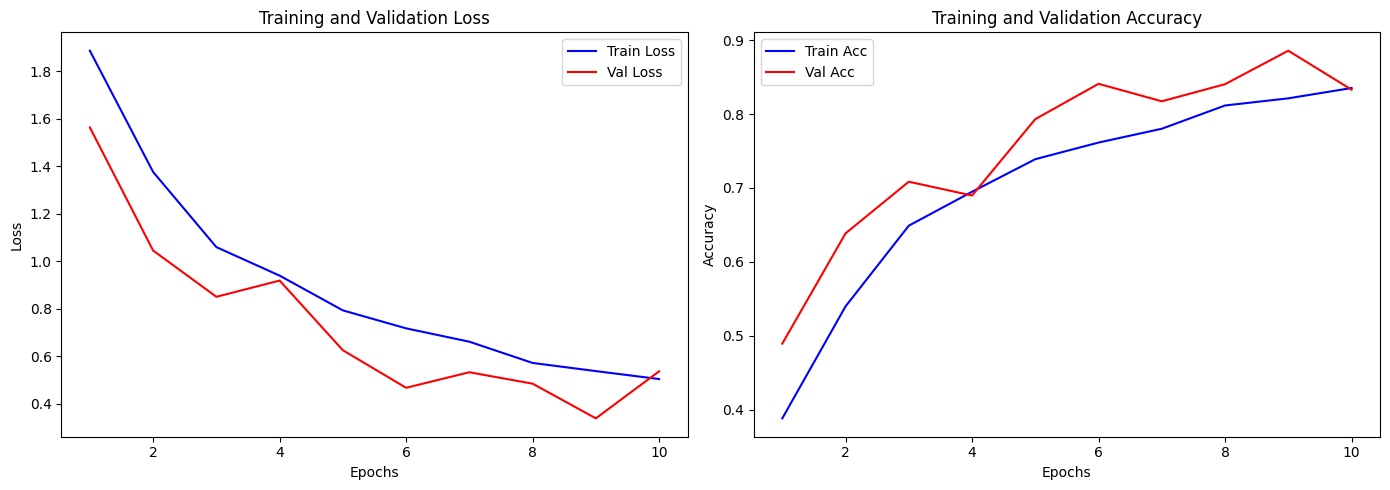

In [12]:
epochs = range(1, 11)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Train Acc')
plt.plot(epochs, val_acc, 'r', label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Record the best accuracy and most loss

In [13]:
most_loss = max(val_loss)
best_accuracy = best_acc.item()

# Print summary

In [14]:
print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Most Loss: {most_loss:.4f}')
print(f'Total Training Time: {training_time // 60:.0f}m {training_time % 60:.0f}s')

Best Accuracy: 0.8858
Most Loss: 1.5640
Total Training Time: 46m 33s
